### Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn import set_config

set_config(display="diagram") #setting this will display your pipelines as seen above

In [54]:
cali = pd.read_csv('data/housing.csv')

In [55]:
cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [56]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [57]:
cali['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [ ]:
# get the data, dropna, one-hot for ocean_proximity
# drop islands because they are too few
# shuffle and split it into 3 sets
# get baselines
# see what the most strongly correlated features are

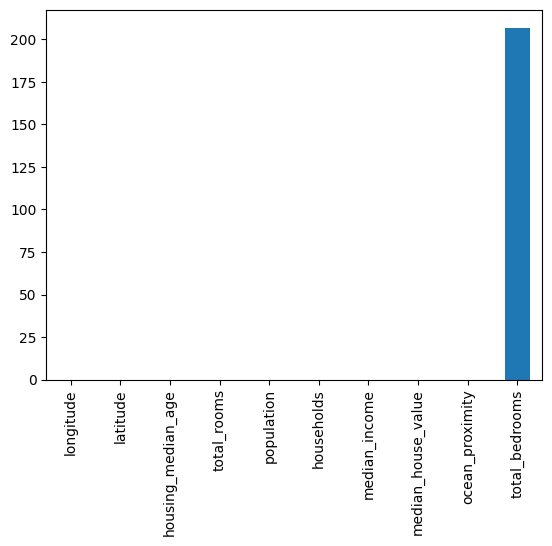

In [58]:
# Create a barplot using `matplotlib` with the $x$-axis representing the columns and the $y$-axis representing the count of missing values
cali.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

# Drop entries missing bedroom data
cali_cleen_1 = cali.dropna()
#cali_cleen_1.info()

# Drop the 5 entries where the ocean proximity is "ISLAND"
cali_cleen_2 = cali_cleen_1.drop(cali_cleen_1.index[cali_cleen_1['ocean_proximity']=='ISLAND'],axis=0)
#cali_cleen_2.info()

## Split into training, validation and test sets

In [59]:
# Shuffle and split into training, validation, and test sets, 20433 is the total num of rows
cali_train, cali_valid, cali_test = np.split( cali_cleen_2.sample(frac = 1), [11_977, 16_023] )

# Drop target feature from valid and test sets
cali_train_X = cali_train.drop('median_house_value', axis = 1)
cali_train_y = cali_train['median_house_value']


c:\Users\sspillane\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [60]:
# Manual Ordinal Encoder to turn ocean_proximity into int values for the correlation function to work in the next step
cali_train_corr = cali_train
cali_train_corr["ocean_proximity"] = cali_train_corr["ocean_proximity"].str.replace("INLAND","0")
cali_train_corr["ocean_proximity"] = cali_train_corr["ocean_proximity"].str.replace("<1H OCEAN","1")
cali_train_corr["ocean_proximity"] = cali_train_corr["ocean_proximity"].str.replace("NEAR BAY","2")
cali_train_corr["ocean_proximity"] = cali_train_corr["ocean_proximity"].str.replace("NEAR OCEAN","3")

cali_train_corr["ocean_proximity"] = cali_train_corr["ocean_proximity"].astype(int)

cali_train_corr.head(14)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
688,-122.12,37.71,38,1164,284.0,632,289,3.0345,152100,2
4609,-118.29,34.08,49,649,315.0,987,329,1.6806,316700,1
18130,-122.02,37.35,22,3219,756.0,1479,667,4.1473,354400,1
10975,-117.84,33.76,22,378,78.0,196,81,3.6806,219400,1
13843,-117.32,34.54,9,5904,1165.0,3489,1063,3.1250,92800,0
11700,-117.97,33.88,9,1344,279.0,530,265,5.0731,185100,1
19589,-120.83,37.58,30,1527,256.0,757,240,3.6629,171400,0
4102,-118.39,34.14,19,5076,1034.0,2021,960,5.5683,309200,1
8733,-118.31,33.83,50,696,311.0,382,234,2.7750,225000,1
1757,-122.33,37.95,42,1627,336.0,848,316,3.7708,144600,2


In [61]:
# to id and view the most closely correlated features. from 8.7 #3
highest_corr = cali_train_corr.corr()[['median_house_value']].nlargest(columns = 'median_house_value', n = 10).index[:]
print(highest_corr)
highest_corr_values = cali_train_corr.corr()[['median_house_value']].nlargest(columns = 'median_house_value', n = 10)
print(highest_corr_values)
# sns.heatmap(cali_train_corr.corr(), annot=True)

Index(['median_house_value', 'median_income', 'ocean_proximity', 'total_rooms',
       'housing_median_age', 'households', 'total_bedrooms', 'population',
       'longitude', 'latitude'],
      dtype='object')
                    median_house_value
median_house_value            1.000000
median_income                 0.684935
ocean_proximity               0.380111
total_rooms                   0.129493
housing_median_age            0.115569
households                    0.061338
total_bedrooms                0.046685
population                   -0.030629
longitude                    -0.051750
latitude                     -0.140019


In [66]:
ordinal_transformer = make_column_transformer( (OrdinalEncoder(categories = [['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN']]), ['ocean_proximity']),
                                                remainder='passthrough')

In [67]:
ordinal_transformer.fit_transform(cali_train_X[['ocean_proximity']])[:5]

array([[2.],
       [1.],
       [1.],
       [1.],
       [0.]])

In [ ]:
# See 8.7 #6 for adding more columns
pipe_1_col = Pipeline([
                ('col_transformer', ordinal_transformer),
                ('linreg', LinearRegression())
            ])
pipe_1_col.fit(cali_train[['median_income']], cali_train['median_house_value'])

In [73]:
cali_train_X = cali_train.drop('median_house_value', axis = 1)
cali_train_y = cali_train['median_house_value']
cali_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
688,-122.12,37.71,38,1164,284.0,632,289,3.0345,152100,2
4609,-118.29,34.08,49,649,315.0,987,329,1.6806,316700,1
18130,-122.02,37.35,22,3219,756.0,1479,667,4.1473,354400,1
10975,-117.84,33.76,22,378,78.0,196,81,3.6806,219400,1
13843,-117.32,34.54,9,5904,1165.0,3489,1063,3.1250,92800,0


In [74]:
train_mses = []
test_mses = []

for i in range(1, 11):
    pipeline = Pipeline([
                        #('transformer', ordinal_transformer),
                        ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                        ('linreg', LinearRegression())
                        ])
    pipeline.fit(cali_train[['median_income']], cali_train['median_house_value'])
    train_preds = pipeline.predict(cali_train[['median_income']])
    test_preds = pipeline.predict(cali_train[['median_income']])
    train_mses.append(mean_squared_error(cali_train['median_house_value'], train_preds))
    test_mses.append(mean_squared_error(y1_test, test_preds))

NameError: name 'X_train' is not defined

In [ ]:
pipe_2 = Pipeline([('transformer', ordinal_ohe_transformer), 
                  ('linreg', LinearRegression())])
pipe_2.fit(X_train[['OverallQual', 'CentralAir', 'HeatingQC']], y_train)
pred_train = pipe_2.predict(X_train[['OverallQual', 'CentralAir', 'HeatingQC']])
pred_test = pipe_2.predict(X_test[['OverallQual', 'CentralAir', 'HeatingQC']])
pipe_2_train_mse = mean_squared_error(y_train, pred_train)
pipe_2_test_mse = mean_squared_error(y_test, pred_test)